In [1]:
import pandas as pd
import numpy as np
rng = np.random.default_rng()
from tqdm.notebook import tqdm, trange
tqdm.pandas()
import math, time
import matplotlib.pyplot as plt
%cd /home/jeroen/repos/traffic-scheduling/single
from automaton import Automaton, evaluate
from exact import solve

/home/jeroen/repos/traffic-scheduling/single


We can load the train and test data sets from disk. Skip the next computations in sections "Generate train and test sets" and "Compute optimal solutions" when the optimal solutions have already been computed previously.

In [2]:
data = pd.read_pickle('data/data.pkl')
train, test = {}, {}
for i, row in data.iterrows():
    train[i] = pd.read_pickle(f'data/train_{i}.pkl')
    test[i] = pd.read_pickle(f'data/test_{i}.pkl')

# Crossing time scheduling in a single intersection

First, we analyze the efficiency of the branch-and-cut approach by measuring the average running time over different problem distributions. In particular, we are interested in which type of cutting planes provide the greatest average speed up. Second, we analyze the performance of the various heuristics based on their average optimality gap over some classes of problem instances.

## Instance generation

In [3]:
rho = 4
sigma = 1

There are several ways to characterize the distribution of problem instances, for example
- number of routes,
- number of arrivals per route,
- arrival intensity per route,
- symmetric or assymtric arrival intensities,
- degree of platooning.

A simple way of modeling the natural occurence of platoons in the arrival process is by using a bimodal distribution $F$ for the interarrival times. We will use a mixture of two exponential random variables with different means, representing the small gaps between vehicles in the same platoon and the large gaps between vehicles of different platoons.

In [4]:
def bimodal_exponential(p=0.3, s1=1, s2=10):
    def generate(n):
        ps = rng.binomial(1, p, size=(n))
        return ps * rng.exponential(scale=s1, size=(n)) + (1-ps) * rng.exponential(scale=s2, size=(n))
    return generate

Introduce some helper functions to generate instances.

In [5]:
def empty_instance():
    return { 'switch': sigma, 'release': [], 'length': [] }

def add_route(instance, releases, lengths):
    instance['release'].append(releases)
    instance['length'].append(lengths)

def cumulate(gaps):
    """Compute $A_n = A_{n-1} + X_n + \rho$ for all n, where X_n is given by `gaps`."""
    lengths = np.repeat(rho, len(gaps))
    shifted = np.roll(lengths, 1); shifted[0] = 0
    releases = np.cumsum(gaps + shifted)
    return releases, lengths

We start with simple symmetric instances, where each route has the same interarrival time distribution.

In [6]:
def generate_symmetric_instance(F, n_arrivals, n_routes=2):
    """F is a function to generate interarrival times."""
    instance = empty_instance()
    for _ in range(n_routes):
        gaps = F(n_arrivals)
        add_route(instance, *cumulate(gaps))
    return instance

## Measure branch-and-cut running time

We measure the average running time of the MILP-solver for different selections of cutting planes. To prevent running times blowing up, we use a fixed time-out for each instance. For this analysis, we do not keep track of the optimal schedule for comparison, we will compute these later, with larger time bound.

In [8]:
from itertools import combinations
from math import isclose

def measure_exact(instances, cuts=None, timelimit=60, with_done=True):
    data = pd.DataFrame(zip(instances), columns=['instance'])
    
    def solve_instance(row, cuts):
        start = time.time()
        res = solve(row['instance'], timelimit=timelimit, cutting_planes=cuts)
        return time.time() - start, res['done'], res['obj']

    cid = lambda cuts: ''.join(str(c) for c in cuts)
    for c in cuts:
        data[[f'running_time_{cid(c)}', f'done_{cid(c)}', f'obj_{cid(c)}']] = \
            data.progress_apply(lambda x: solve_instance(x, c), axis=1, result_type='expand')

    # little test to verify cutting planes: check if pairwise objectives match
    # for c1, c2 in combinations(cuts, 2):
    #     data['matching'] = data.apply(lambda x: isclose(x[f'obj_{cid(c1)}'], x[f'obj_{cid(c2)}'], abs_tol=1e-02), axis=1)
    #     assert data['matching'].all()
    
    data = data.drop(['instance', 'matching'], axis=1, errors='ignore')
    data = data.drop([f'obj_{cid(c)}' for c in cuts], axis=1)
    if not with_done:
        data = data.drop([f'done_{cid(c)}' for c in cuts], axis=1)
    return data

In [19]:
timelimit = 60

F = bimodal_exponential(p=0.5, s1=0.1, s2=10)
ns = [5, 10, 15, 20, 25, 30, 35, 40]
cuts = [[1], [2], [3]]
N = 20

from datetime import datetime, timedelta
bound = timedelta(seconds=len(ns) * len(cuts) * N * timelimit)
print(f"runtime upper bound: {bound}")

runtime upper bound: 8:00:00


Note that running times might become "censored" due to the use of a time limit. We need to deal with this in the generation of the plots.

In [ ]:
started = datetime.now()
print(f"started: {started.strftime('%H:%M:%S')}")
end = started + bound
print(f"done before: {end.strftime('%H:%M:%S')}")

data = []
for n in ns:
    print(n)
    instances = [generate_symmetric_instance(F, n) for _ in range(N)]
    rows = measure_exact(instances, cuts=cuts, timelimit=timelimit, with_done=False)
    rows['n'] = n
    data.append(rows)

total = pd.concat(data, ignore_index=True).set_index('n').groupby('n').mean()
total.to_pickle(f'data/running_times.pkl')

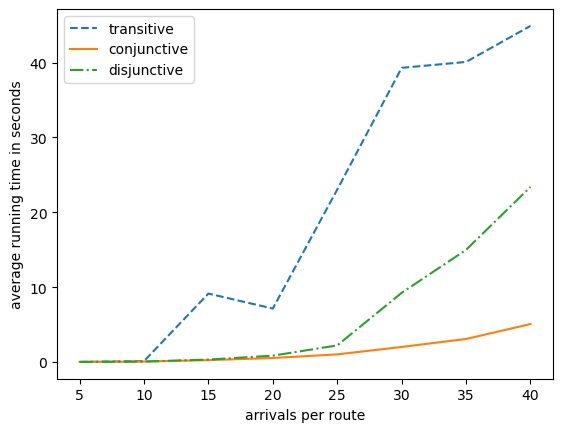

In [29]:
total.plot(style=['--','-','-.'])
#'--', '-.', '-', ':']
plt.legend(['transitive', 'conjunctive', 'disjunctive'])
plt.xlabel('arrivals per route')
plt.ylabel('average running time in seconds')
plt.savefig(f'../report/data-single/running_times.pdf')
plt.show()
plt.close()

## Generate train and test sets

Define a series of problem instance specifications. We define three different types of platoon occurence: large isolated platoons, frequent small platoons, very regular (almost no platoons).

In [7]:
data = pd.DataFrame([
    [0, 10], [0, 30], [0, 50],
    [1, 10], [1, 30], [1, 50],
    [2, 10], [2, 30], [2, 50],
])
data.columns = ['gen_id', 'n_arrivals']
data['set_name'] = data.apply(lambda row: ['low', 'med', 'high'][row['gen_id']], axis=1)
data.index.name = 'set_id'
data

,gen_id,n_arrivals,set_name
set_id,,,
0,0,10,low
1,0,30,low
2,0,50,low
3,1,10,med
4,1,30,med
5,1,50,med
6,2,10,high
7,2,30,high
8,2,50,high


In [8]:
# interarrival time distributions 'low', 'med' and 'high', with same arrival intensity using s2 = (mu - p*s1) / (1 - p)
Fs = [
    bimodal_exponential(p=0.5, s1=0.1, s2=10),
    bimodal_exponential(p=0.3, s1=0.1, s2=7.171428571428572),
    bimodal_exponential(p=0.1, s1=0.1, s2=5.6),
]

To give an idea of these arrival distributions, we plot some arrivals for a single route.

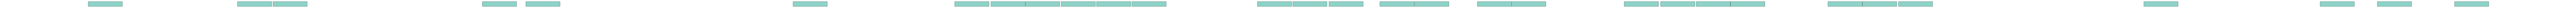

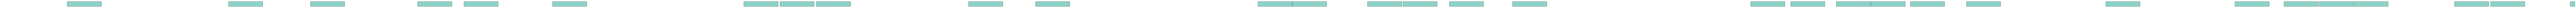

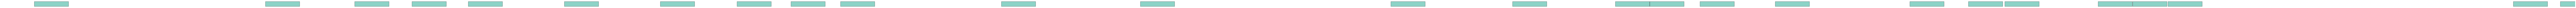

In [9]:
from util import plot_schedule
n_arrivals = 50
for F in Fs:
    instance = empty_instance()
    gaps = F(n_arrivals)
    add_route(instance, *cumulate(gaps))
    plot_schedule(instance, clean=True, custom_end_time=300)

For each specification, we generate some training instances and some test instances that will be used in the final optimality evaluation.

In [10]:
N_train, N_test = 100, 100
train, test = {}, {}
for i, row in data.iterrows():
    n = row['n_arrivals']
    f = lambda: generate_symmetric_instance(Fs[row['gen_id']], n)
    train[i] = pd.DataFrame(zip([f() for _ in range(N_train)]), columns=['instance'])
    test[i] = pd.DataFrame(zip([f() for _ in range(N_test)]), columns=['instance'])

Alternatively, we can load the train and test data sets from disk. Skip the computations in the next section "Compute optimal solutions" when the optimal solutions are already included.

In [10]:
data = pd.read_pickle('data/data.pkl')
train, test = {}, {}
for i, row in data.iterrows():
    train[i] = pd.read_pickle(f'data/train_{i}.pkl')
    test[i] = pd.read_pickle(f'data/test_{i}.pkl')

Define helper method to compute the normalized objective (delay) for comparison across different instance sizes.

In [11]:
def normalize_objective(results, data):
    total = 0
    for res, instance in zip(results, data['instance']):
        size = sum(len(rs) for rs in instance['release'])
        total += (res - np.sum(instance['release'])) / size
    return total / len(results)

## Compute optimal solutions

We use the best cutting plane selected in the previous section to compute the optimal solutions, where possible. Whenever it becomes too expensive to compute the optimal solution, we use the best solution obtained by MILP after a certain time limit. These optimal solutions are also used for the neural heuristic when imitation learning is employed. We save the computed train and test data sets to disk to avoid having to recompute the expensive optimal solutions.

In [ ]:
from util import lane_order

timelimit_opt = 60

def solve_instance(x):
    res = solve(x['instance'], timelimit=timelimit_opt, cutting_planes=[2])
    return res['y'], res['obj'], res['done'], res['gap'], res['time']

start = time.time()
for i, row in data.iterrows():
    print(f'set {row['n_arrivals'], row['set_name']}')
    cols = ['opt_y', 'opt_obj', 'opt_done', 'opt_gap', 'opt_time']
    train[i][[*cols]] = train[i].progress_apply(solve_instance, axis=1, result_type='expand')
    test[i][[*cols]] = test[i].progress_apply(solve_instance, axis=1, result_type='expand')
    
    # compute optimal lane order for training instances (for imitation learning)
    train[i]['opt_eta'] = train[i].apply(lambda x: lane_order(x['opt_y']), axis=1)

    # save to disk
    train[i].to_pickle(f'data/train_{i}.pkl')
    test[i].to_pickle(f'data/test_{i}.pkl')
print(f'total computation time: {time.time() - start}')

# take mean objective and running time over all test instances
data['opt_obj'] = data.apply(lambda row: normalize_objective(test[row.name]['opt_obj'], test[row.name]['instance']), axis=1)
data['opt_time'] = data.apply(lambda row: test[row.name]['opt_time'].mean(), axis=1)
data.to_pickle('data/data.pkl')

## Threshold heuristic

In [12]:
def threshold_heuristic(automaton, tau=0):
    """Stay on lane while next unscheduled vehicle is close enough."""
    if automaton.last_lane is None:
        # default first lane is "earliest lane"
        first_vehicles = { l: automaton.LB[l][0] for l in range(automaton.N) }
        l = min(first_vehicles, key=first_vehicles.get)
    else:
        l = automaton.last_lane
    
    # last scheduled vehicle
    k = automaton.k[l] - 1

    # next vehicle exists
    if k + 1 < automaton.K[l]:
        # earliest crossing time of next vehicle in lane
        r = automaton.instance['release'][l][k+1]

        if automaton.LB[l][k] + automaton.instance['length'][l][k] + tau >= r:
            return l

    # next lane with unscheduled vehicles
    l = (l + 1) % automaton.N
    while automaton.k[l] == automaton.K[l]:
        l = (l + 1) % automaton.N
    return l

# "exhaustive" heuristic is just threshold heuristic with tau=0
exhaustive_heuristic = lambda x: threshold_heuristic(x, tau=0)

We tune the threshold based on a set of training instances and measure the peformance on a test set.

In [17]:
taus = np.arange(0.1, 4.1, 0.05)
threshold_train_scores = []
threshold_train_times = {}

def train_threshold(train, set_id):
    # evaluate threshold heuristic on every instance to get average objective
    train_scores = np.empty((taus.shape[0]))
    start = time.time()
    for i, tau in enumerate(tqdm(taus, desc=f"{set_id} training", leave=False)):
        heuristic = lambda automaton: threshold_heuristic(automaton, tau=tau)
        results = train.apply(lambda x: evaluate(x['instance'], heuristic), axis=1)
        # store normalized train score
        train_scores[i] = normalize_objective(results, train)

    threshold_train_times[set_id] = time.time() - start
    threshold_train_scores.append(train_scores)
    return taus[np.argmin(train_scores)]

def eval_threshold(train, test, set_id):
    tau_opt = train_threshold(train, set_id)
    heuristic = lambda automaton: threshold_heuristic(automaton, tau=tau_opt)
    tqdm.pandas(desc=f"{set_id} evaluating")
    results = test.progress_apply(lambda x: evaluate(x['instance'], heuristic), axis=1)
    return tau_opt, normalize_objective(results, test)

def eval_exhaustive(test, set_id):
    tau_opt = 0
    heuristic = lambda automaton: threshold_heuristic(automaton, tau=tau_opt)
    tqdm.pandas(desc=f"{set_id} evaluating")
    results = test.progress_apply(lambda x: evaluate(x['instance'], heuristic), axis=1)
    return normalize_objective(results, test)

## Neural heuristic

In [13]:
import torch
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.utils.data import TensorDataset, DataLoader, random_split

We use the optimal solutions obtained in for the training data set to train the model by imitation learning.

In [14]:
neural_train_losses = []
neural_val_losses = []
neural_train_times = {}

# instead of epochs, we provide the total number of individual training steps,
# to support fair comparison across different training data sets
total_steps = 500
# compute validation loss each time this number of steps has been processed
val_steps = 20
# we define both the above numbers globally, because we need it to determine
# the correct time epochs when plotting the validation losses

def train_neural(train, model, set_id):
    start = time.time()

    # extracting state-action (state, next_lane) pairs by replaying optimal lane ordering
    states, actions = [], []
    for _, row in tqdm(train.iterrows(), desc=f"{set_id} extracting", total=train.shape[0], leave=False):
        instance, eta = row[['instance', 'opt_eta']]
        eta = iter(eta)
        automaton = Automaton(instance)
        while not automaton.done:
            lane = next(eta)
            state = model.state_transform(automaton)
            action = model.inverse_action_transform(automaton, lane)
            automaton.step(lane)
            states.append(state)
            actions.append(action)

    batch_size = 20
    val_frac = 0.1 # fraction of state-action pairs used for validation

    state_action_pairs = TensorDataset(torch.vstack(states), torch.vstack(actions))
    train_set, val_set = random_split(state_action_pairs, [1 - val_frac, val_frac])    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set)

    learning_rate = 5e-4
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    params = []
    step = 0
    with tqdm(total=total_steps, desc=f"{set_id} training", leave=False) as pbar:
        while True:
            for s, a in train_loader:
                # perform a single training step
                model.train()
                optimizer.zero_grad()
                loss = binary_cross_entropy_with_logits(model(s), a)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

                step += 1
                pbar.update(1)
                
                if step % val_steps == 0:
                    # store current model parameters        
                    params.append(model.state_dict())
                    # validate current model
                    model.eval()
                    val_loss = 0
                    for s, a in val_loader:
                        val_loss += binary_cross_entropy_with_logits(model(s), a)
                    val_losses.append(val_loss.detach().cpu() / len(val_loader)) # average over validation set

                if step >= total_steps: break # ...out of inner loop
            if step >= total_steps: break # ...out of outer loop

    # select model with minimal validation loss
    i = val_losses.index(min(val_losses))
    model.load_state_dict(params[i])

    # record data for reporting
    neural_train_times[set_id] = time.time() - start
    neural_train_losses.append(train_losses)
    neural_val_losses.append(val_losses)
    return model

In [15]:
from model import RecurrentEmbeddingModel

def eval_neural(train, test, set_id, Model=RecurrentEmbeddingModel):
    lanes = len(train['instance'][0]['release'])
    max_veh = len(train['instance'][0]['release'][0])
    model = Model(lanes=lanes, max_horizon=max_veh).cuda()
    model = train_neural(train, model, set_id)    
    model.eval()
    heuristic = model.greedy_heuristic

    def eval(row):
        instance = row['instance']
        obj = evaluate(instance, heuristic)
        return obj

    tqdm.pandas(desc=f"{set_id} evaluating")
    results = test.progress_apply(eval, axis=1, result_type='expand')
    return normalize_objective(results, test)

## Collect and report measurements

Run all the analyses at once, without any kind of checkpoints.

In [ ]:
data['exhaustive_obj'] = data.apply(lambda row: eval_exhaustive(test[row.name], row.name), axis=1)

In [ ]:
data[['threshold_tau', 'threshold_obj']] = \
    data.apply(lambda row: eval_threshold(train[row.name], test[row.name], row.name), axis=1, result_type='expand')
data['threshold_train_time'] = threshold_train_times

In [ ]:
data['neural_obj'] = \
    data.apply(lambda row: eval_neural(train[row.name], test[row.name], row.name, Model=RecurrentEmbeddingModel), axis=1)
data['neural_train_time'] = neural_train_times

### Threshold heuristic fit

Plot the train scores for the various thresholds to verify the model fit.

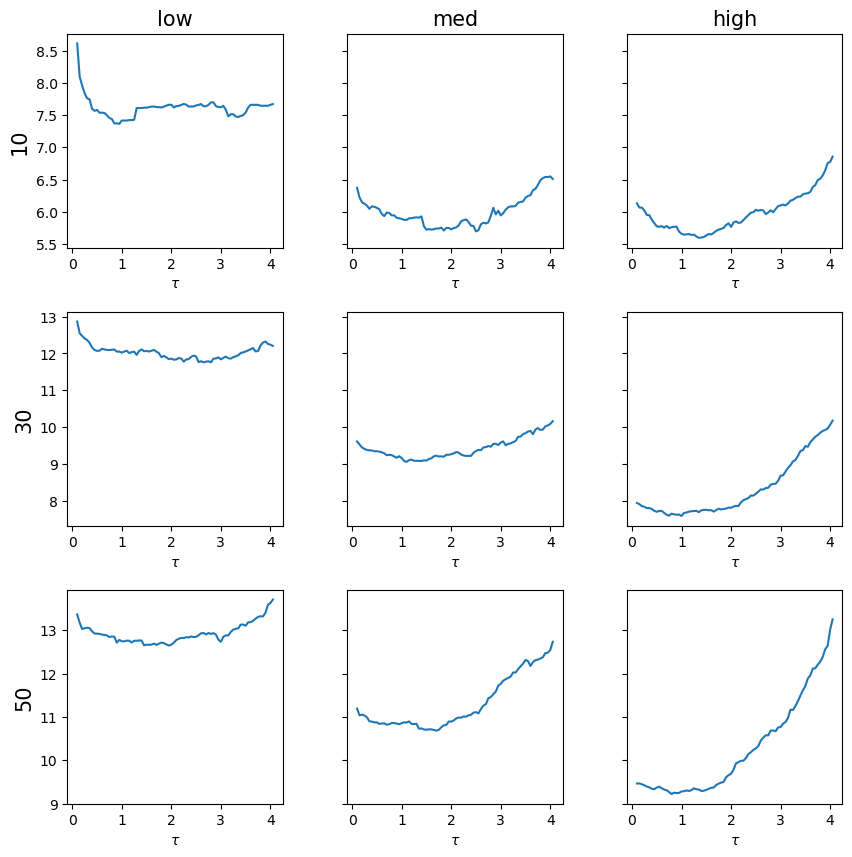

In [59]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(nrows=math.ceil(len(threshold_train_scores) / 3), ncols=3, hspace=0.3, wspace=0.3)
axes = gs.subplots(sharey='row')
for ax, train_scores in zip(axes.T.flatten(), threshold_train_scores):
    ax.plot(taus, train_scores)
    ax.set(xlabel='$\\tau$')

for ax, label in zip(axes[:, 0], ['10', '30', '50']):
    ax.set_ylabel(label, size=15)
for ax, label in zip(axes[0, :], ['low', 'med', 'high']):
    ax.set_title(label, size=15)
plt.savefig(f'threshold_tau_fit.pdf')

### Neural heuristic fit

Plot the loss during training.

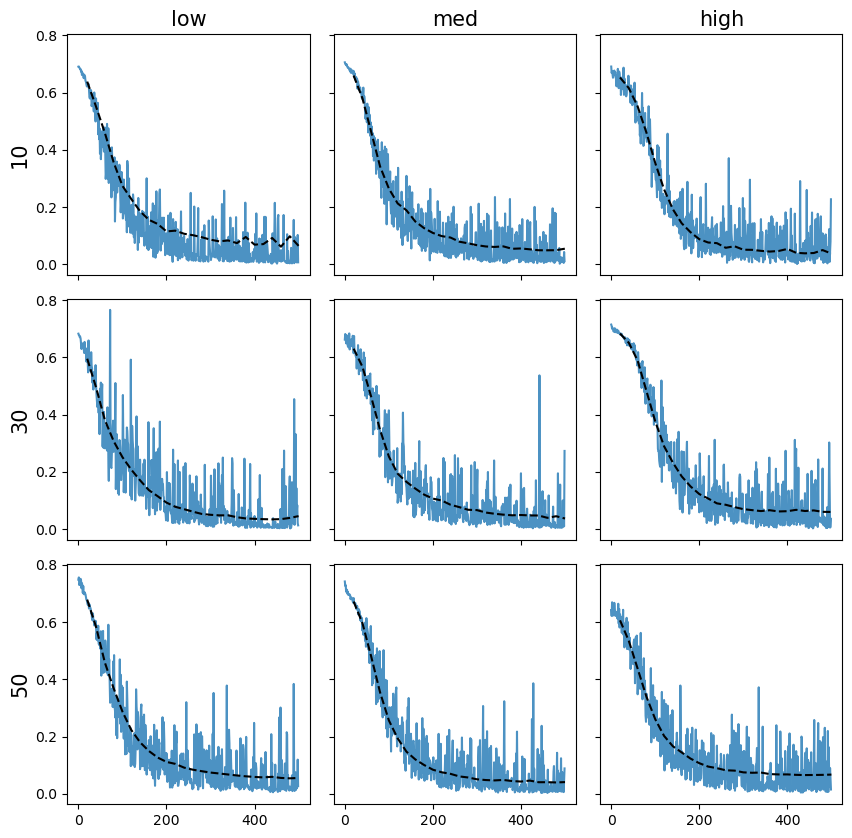

In [60]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(nrows=math.ceil(len(neural_train_losses) / 3), ncols=3, hspace=0.1, wspace=0.1)
axes = gs.subplots(sharex=True, sharey=True)
for ax, train_losses, val_losses in zip(axes.T.flatten(), neural_train_losses, neural_val_losses):
    ax.plot(train_losses, alpha=0.8, label='training')
    val_t = np.array(range(1, 1 + total_steps // val_steps)) * val_steps
    ax.plot(val_t, val_losses, '--k', label='validation')
    #ax.set(xlabel='step')
    
for ax, label in zip(axes[:, 0], ['10', '30', '50']):
    ax.set_ylabel(label, size=15)
for ax, label in zip(axes[0, :], ['low', 'med', 'high']):
    ax.set_title(label, size=15)

#plt.legend() # single legend in last ax
plt.savefig(f'neural_sl_fit.pdf')

### Report and export

In [61]:
# compute (relative) approximation ratios
data['exhaustive_gap'] = data.apply(lambda row: row['exhaustive_obj'] / row['opt_obj'], axis=1)
data['threshold_gap'] = data.apply(lambda row: row['threshold_obj'] / row['opt_obj'], axis=1)
data['neural_gap'] = data.apply(lambda row: row['neural_obj'] / row['opt_obj'], axis=1)
# format as "obj (gap)" strings
data['exhaustive'] = data.apply(lambda row: f"{row['exhaustive_obj']:4.2f} ({(row['exhaustive_gap'] - 1) * 100:.2f}\\%)", axis=1)
data['threshold'] = data.apply(lambda row: f"{row['threshold_obj']:4.2f} ({(row['threshold_gap'] - 1) * 100:.2f}\\%)", axis=1)
data['neural'] = data.apply(lambda row: f"{row['neural_obj']:4.2f} ({(row['neural_gap'] - 1) * 100:.2f}\\%)", axis=1)

Save the results to `results.csv` to produce tables in the report.

In [62]:
data.drop(['gen_id'], axis=1, errors='ignore').round(2).to_csv('../report/data-single/results.csv', index=False)

## Local search

We want to see if we can further improve the quality of the found solution by moving vehicles a little bit around.

In [96]:
instance = generate_instances(1, 10)[0]
y1 = threshold_heuristic(instance, opt_threshold)
print(objective(y1))
y2 = neural_heuristic(instance, model)
print(objective(y2))
plot_schedule(instance, [{'y': y1}, {'y': y2}], out='comparison.pdf', draw_switch=True)

1152.64685436669
1130.142116586026


In [97]:
# 0. compute initial lane order from heuristic schedule

# repeat:
# 1. from current lane order, move vehicle to prev/next platoon
# 2. recompute LB's -> objective
# 3. accept/deny these steps based on change in objective

In [32]:
def execute_lane_order(instance, lane_order):
    # For now, we just replay the lanes on the automaton.
    # However, this is not very efficient...
    automaton = Automaton(instance)
    lane = iter(lane_order)
    while not automaton.done:
        automaton.step(next(lane))
    return automaton.y

We use `platoon_id` to identify a platoon in the lane order. For example, given lane order `[0,0,0,1,1,1,1,0,0,1,1,0]`, the second platoon with `platoon_id == 1` belongs to lane 1 and consists of 4 vehicles.

In [41]:
def platoon(lane_order, platoon_id):
    """Returns the range as `(start_id, end_id)` of the platoon with `platoon_id`."""
    start = 0
    p = 0
    prev_l = lane_order[0]
    for i, l in enumerate(lane_order):
        if prev_l != l:
            p += 1
            if p == platoon_id:
                start = i
            if p == platoon_id + 1:
                return start, i - 1
        prev_l = l
    return start, i

In [54]:
def total_platoons(lane_order):
    """Count the total number of platoons."""
    prev_l = lane_order[0]
    total = 1
    for l in lane_order:
        if prev_l != l:
            total += 1
        prev_l = l
    return total

In [64]:
def swap(lane_order, i, j):
    """Swap the lanes at position `i` with position `j` in `lane_order`."""
    new_order = list(lane_order) # make copy
    new_order[i] = lane_order[j]
    new_order[j] = lane_order[i]
    return new_order

In [69]:
def swap_prev(lane_order, platoon_id):
    """Assumes N=2 lanes."""
    if platoon_id == 0:
        raise Exception("Cannot swap first platoon to previous.")
    
    # swap starts
    i, _ = platoon(lane_order, platoon_id)
    j, _ = platoon(lane_order, platoon_id - 1)
    return swap(lane_order, i, j)

def swap_next(lane_order, platoon_id):
    """Assumes N=2 lanes."""
    P = total_platoons(lane_order)
    if platoon_id >= P:
        raise Exception("Cannot swap last platoon to next.")

    # swap ends
    _, i = platoon(lane_order, platoon_id)
    _, j = platoon(lane_order, platoon_id + 1)
    return swap(lane_order, i, j)

In [102]:
def neighbors(lane_order):
    P = total_platoons(lane_order)
    candidates = []
    for p in range(0, P - 1):
        candidates.append(swap_next(lane_order, p))
    for p in range(1, P):
        candidates.append(swap_prev(lane_order, p))
    return candidates

In [113]:
def local_search(instance, lane_order):
    current_obj = objective(execute_lane_order(instance, lane_order))
    while True:
        scores = []
        candidates = neighbors(lane_order)
        for candidate in candidates:
            scores.append(objective(execute_lane_order(instance, candidate)))
    
        new_obj = min(scores)
        if new_obj < current_obj:
            lane_order = candidates[scores.index(new_obj)]
            current_obj = new_obj
        else:
            return lane_order, current_obj

In [116]:
from util import lane_order
l = lane_order(y2)
print(l, objective(y2))
local_search(instance, l)

instances = generate_instances(100, 40)

print(f"threshold heuristic (plain): {evaluate_threshold_heuristic(instances, opt_threshold)}")
print(f"neural heuristic (plain): {evaluate_neural_heuristic(instances, model)}")

def evaluate_heuristic_local_search(instances, heuristic):
    score = 0
    for instance in instances:
        y = heuristic(instance)
        _, obj = local_search(instance, lane_order(y))
        score += obj
    return score / len(instances)

print(f"threshold heuristic (local search): {evaluate_heuristic_local_search(instances, lambda i: threshold_heuristic(i, opt_threshold))}")
print(f"threshold heuristic (local search): {evaluate_heuristic_local_search(instances, lambda i: neural_heuristic(i, model))}")

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1] 1130.142116586026
threshold heuristic (plain): 18726.09255776797
neural heuristic (plain): 18165.76017238903
threshold heuristic (local search): 18275.405433586347
threshold heuristic (local search): 18142.39177915429


## Reinforcement learning neural heuristic

We first check our definition of rewards, by verifying that the total episodic reward equals the difference between the schedule objective for the initial empty schedule and the final complete schedule.

In [16]:
from random import choice

i = choice(range(len(train[0])))
print(f"instance {i}")
instance = train[0]['instance'][i]
automaton = Automaton(instance)

initial_objective = automaton.get_objective()
total_reward = 0
while not automaton.done:
    # take random action
    action = choice([ r for r in range(automaton.N) if automaton.k[r] < automaton.K[r] ])
    reward = automaton.step(action)
    total_reward += reward
print(f"total reward: {total_reward}")
print(f"additional objective: {automaton.get_objective() - initial_objective}")

assert math.isclose(total_reward, initial_objective - automaton.get_objective()), "Objectives do not match!"

instance 77
total reward: -391.6539705578891
additional objective: 391.6539705578891


Instead of using expert demonstration in the form of state-action pairs, obtained from exact solutions, we are now going to train the neural heuristic using reinforcement learning, i.e., by directly interacting with the automaton.

In [60]:
from model import RecurrentEmbeddingModel
from torch.nn.functional import softmax
from torch.distributions import Bernoulli
from copy import deepcopy
eps = np.finfo(np.float32).eps.item()


def train_rl_neural(model, set_id, baseline='episodic'):
    """Train neural heuristic using REINFORCE with baseline. The baseline can be computed in two ways:
    - 'episodic': Compute the schedule using the exhaustive policy, starting
                  from the instance (empty disjunctive graph). This provides
                  an estimate of the total cost of the schedule.
    - 'stepwise': At each step in the episode, complete the current partial 
                  schedule using the exhaustive policy to estimate the 
                  remaining cost of the schedule.
    """
    start = time.time()

    learning_rate = 1e-4
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    n = data['n_arrivals'][set_id]
    F = Fs[data['gen_id'][set_id]]
    f = lambda: generate_symmetric_instance(F, n)

    train_rewards = []
    train_losses = []

    for _ in trange(5000, desc=f"{set_id} training", leave=False):
        instance = f()
        automaton = Automaton(instance)

        episode_logprobs = []  # log pi(A_t | S_t) for every t
        episode_rewards = []   # rewards R_t for every t
        episode_baselines = [] # baselines b(S_t) for every t
        total_reward = 0
        while not automaton.done:
            s = model.state_transform(automaton)
            m = Bernoulli(logits=model(s))
            action = m.sample()
            episode_logprobs.append(m.log_prob(action))
            action = int(action.item())

            # calculate state baseline
            if baseline == 'stepwise':
                b = automaton.get_objective() - evaluate(deepcopy(automaton), exhaustive_heuristic)
                episode_baselines.append(b)

            action = model.action_transform(automaton, action)
            reward = automaton.step(action)
            episode_rewards.append(reward)
            total_reward += reward

        if baseline == 'stepwise':
            # compute returns from rewards
            returns = torch.tensor(episode_rewards)
            returns = returns + torch.sum(returns) - torch.cumsum(returns, dim=0)
            # normalize the returns
            #returns = (returns - returns.mean()) / (returns.std() + eps)

            loss = []
            for R, b, log_prob in zip(returns, episode_baselines, episode_logprobs):
                loss.append(-log_prob * (R - b))
        else:
            b = 0
            if baseline == 'episodic':
                b = - (evaluate(instance, exhaustive_heuristic) - np.sum(instance['release']))
            loss = []
            for log_prob in episode_logprobs:
                loss.append(-log_prob * (total_reward - b))

        optimizer.zero_grad()
        loss = torch.cat(loss).sum()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_rewards.append(total_reward)

    train_time = time.time() - start
    return model, train_time, train_losses


def eval_rl_neural(test, set_id, baseline, Model=RecurrentEmbeddingModel):
    lanes = len(test['instance'][0]['release'])
    max_veh = len(test['instance'][0]['release'][0])
    model = Model(lanes=lanes, max_horizon=max_veh).cuda()
    model, train_time, train_losses = train_rl_neural(model, set_id, baseline=baseline)

    model.eval()
    heuristic = model.greedy_heuristic
    def eval(row):
        instance = row['instance']
        obj = evaluate(instance, heuristic)
        return obj
    tqdm.pandas(desc=f"{set_id} evaluating")
    results = test.progress_apply(eval, axis=1, result_type='expand')

    return normalize_objective(results, test), train_time, train_losses

In [61]:
rl_neural_train_losses_episodic = []
rl_neural_train_losses_stepwise = []

for i, row in data.iterrows():
    obj, train_time, train_losses = eval_rl_neural(test[i], i, 'episodic', Model=RecurrentEmbeddingModel)
    rl_neural_train_losses_episodic.append(train_losses)
    data.loc[i, 'rl_neural_episodic_obj'] = obj
    data.loc[i, 'rl_neural_episodic_time'] = train_time
    
    obj, train_time, train_losses = eval_rl_neural(test[i], i, 'stepwise', Model=RecurrentEmbeddingModel)
    rl_neural_train_losses_stepwise.append(train_losses)
    data.loc[i, 'rl_neural_stepwise_obj'] = obj
    data.loc[i, 'rl_neural_stepwise_time'] = train_time

0 training:   0%|          | 0/5000 [00:00<?, ?it/s]

0 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

0 training:   0%|          | 0/5000 [00:00<?, ?it/s]

0 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

1 training:   0%|          | 0/5000 [00:00<?, ?it/s]

1 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

1 training:   0%|          | 0/5000 [00:00<?, ?it/s]

1 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

2 training:   0%|          | 0/5000 [00:00<?, ?it/s]

2 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

2 training:   0%|          | 0/5000 [00:00<?, ?it/s]

2 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

3 training:   0%|          | 0/5000 [00:00<?, ?it/s]

3 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

3 training:   0%|          | 0/5000 [00:00<?, ?it/s]

3 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

4 training:   0%|          | 0/5000 [00:00<?, ?it/s]

4 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

4 training:   0%|          | 0/5000 [00:00<?, ?it/s]

4 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

5 training:   0%|          | 0/5000 [00:00<?, ?it/s]

5 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

5 training:   0%|          | 0/5000 [00:00<?, ?it/s]

5 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

6 training:   0%|          | 0/5000 [00:00<?, ?it/s]

6 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

6 training:   0%|          | 0/5000 [00:00<?, ?it/s]

6 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

7 training:   0%|          | 0/5000 [00:00<?, ?it/s]

7 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

7 training:   0%|          | 0/5000 [00:00<?, ?it/s]

7 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

8 training:   0%|          | 0/5000 [00:00<?, ?it/s]

8 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

8 training:   0%|          | 0/5000 [00:00<?, ?it/s]

8 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

In [62]:
data['rl_neural_episodic_gap'] = data.apply(lambda row: ((row['rl_neural_episodic_obj'] / row['opt_obj']) - 1) * 100, axis=1)
data['rl_neural_stepwise_gap'] = data.apply(lambda row: ((row['rl_neural_stepwise_obj'] / row['opt_obj']) - 1) * 100, axis=1)
data['rl_neural_episodic'] = data.apply(lambda row: f"{row['rl_neural_episodic_obj']:4.2f} ({row['rl_neural_episodic_gap']:.2f}\\%)", axis=1)
data['rl_neural_stepwise'] = data.apply(lambda row: f"{row['rl_neural_stepwise_obj']:4.2f} ({row['rl_neural_stepwise_gap']:.2f}\\%)", axis=1)

In [63]:
data[['opt_obj', 'neural', 'rl_neural_episodic', 'rl_neural_episodic_time', 'rl_neural_stepwise', 'rl_neural_stepwise_time']]

,opt_obj,neural,rl_neural_episodic,rl_neural_episodic_time,rl_neural_stepwise,rl_neural_stepwise_time
set_id,,,,,,
0,5.290500,5.34 (0.92\%),5.73 (8.27\%),92.423450,5.54 (4.81\%),125.941488
1,8.598378,8.70 (1.15\%),9.81 (14.05\%),290.473190,9.17 (6.67\%),782.596330
2,11.025562,11.15 (1.15\%),12.38 (12.32\%),517.159924,12.13 (9.99\%),2423.149711
3,4.462605,4.53 (1.44\%),4.85 (8.65\%),94.256669,4.66 (4.42\%),128.556693
4,6.985370,7.10 (1.62\%),8.34 (19.42\%),296.287219,7.77 (11.22\%),789.753201
5,8.553378,8.66 (1.26\%),10.33 (20.80\%),518.251812,10.10 (18.09\%),2434.193129
6,4.470818,4.54 (1.50\%),4.81 (7.49\%),94.932517,4.56 (2.01\%),129.004524
7,6.901877,7.05 (2.13\%),7.88 (14.15\%),295.969591,8.01 (16.07\%),791.479615
8,7.372475,7.52 (1.98\%),8.91 (20.86\%),518.513949,8.41 (14.13\%),2437.069375


In [64]:
data.round(2).to_csv('../report/data-single/results.csv', index=False)

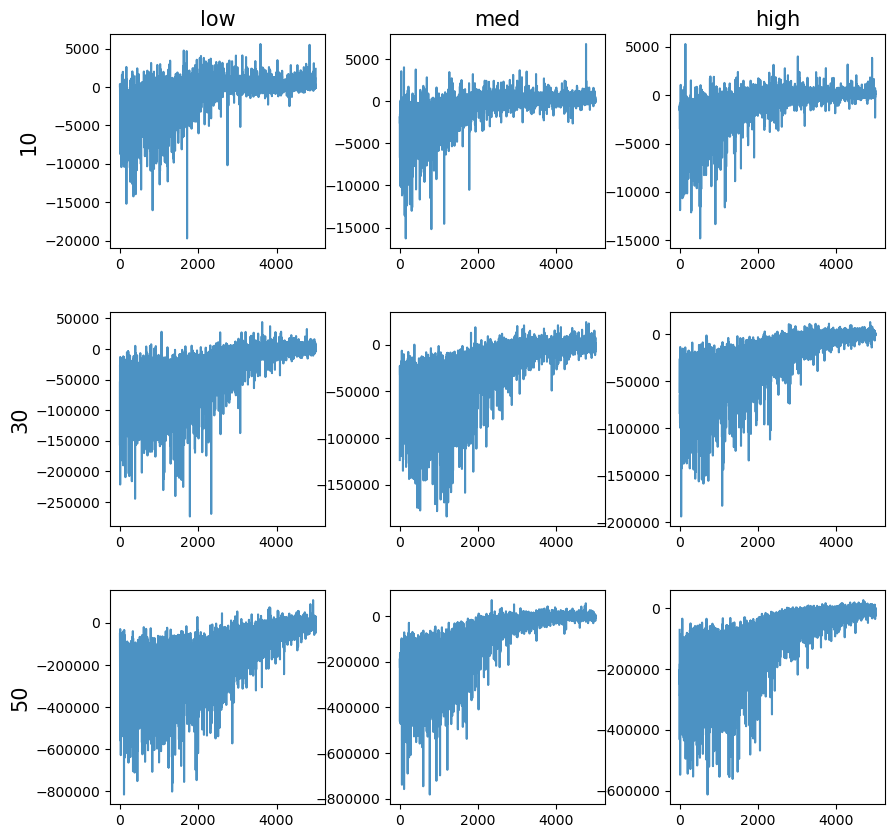

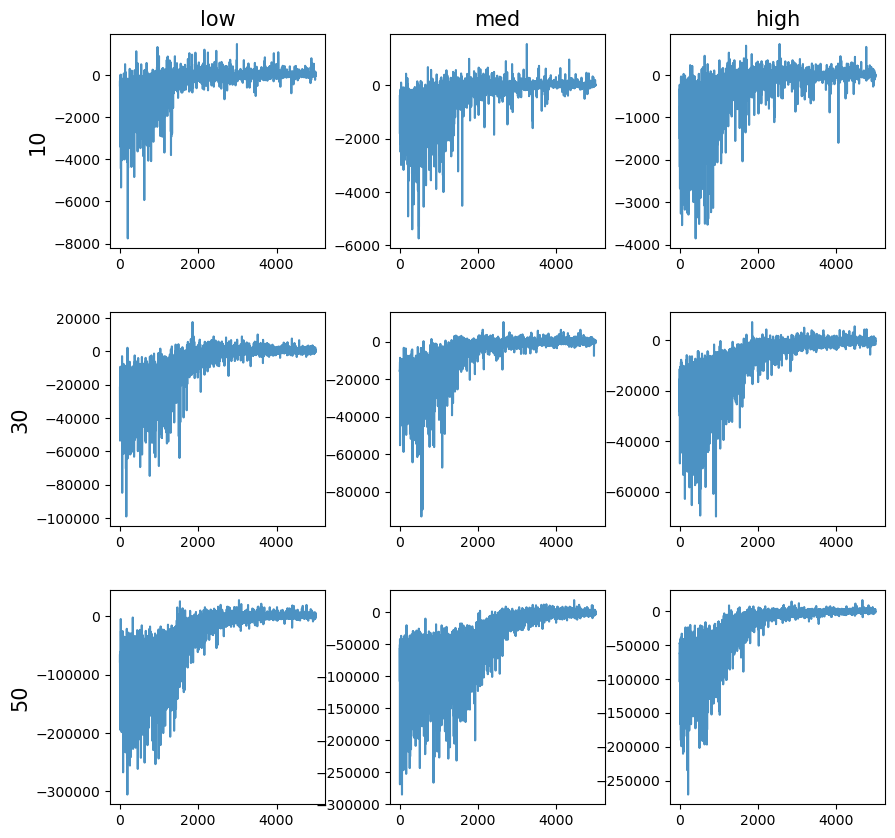

In [65]:
def loss_plot(train_losses):
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(nrows=math.ceil(len(train_losses) / 3), ncols=3, hspace=0.3, wspace=0.3)
    axes = gs.subplots(sharex=False, sharey=False)
    for ax, losses in zip(axes.T.flatten(), train_losses):
        ax.plot(losses, alpha=0.8, label='training')
        
    for ax, label in zip(axes[:, 0], ['10', '30', '50']):
        ax.set_ylabel(label, size=15)
    for ax, label in zip(axes[0, :], ['low', 'med', 'high']):
        ax.set_title(label, size=15)
    
    #plt.legend() # single legend in last ax

loss_plot(rl_neural_train_losses_episodic)
plt.savefig(f'neural_rl_episodic_fit.pdf')
loss_plot(rl_neural_train_losses_stepwise)
plt.savefig(f'neural_rl_stepwise_fit.pdf')